# Evaluation of shear tests 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.tri import  TriAnalyzer,LinearTriInterpolator, Triangulation
from matplotlib.collections import PolyCollection
import numpy as np
import ipywidgets as widgets

# Direction labels
DIRS = ["x", "y", "z"]
# Path to the data
PATH = "Raw/0-01"
# Cross section area
AREA = 1.89 * 24.04

## Load data files

The DIC results are stored in comma seperated files (*.csv) with this structure: 
```
# Units: length:mm angle:deg time:s force:N 
# Stage: Stufe 1
stage;index;relative_time;date
"Stufe 1";1;0.0000;"2024-02-28T13:17:27.881"
# Name : Analogeingang 0
force;untransformed;transformed
1.5354;0.0015;1.5354
# Name : Flächenkomponente 3
id;x;y;z
0;1.7651;18.3950;-0.0050
1;2.0013;18.2682;-0.0028
2;2.1919;18.0722;-0.0025
...
```

Therefore, we begin by reading the files to store forces, facet ids and all facet positions in lists. We pick only the first 800, as the later ones are beyond the elastic regime anyway and they contain a lot of lost facets.

In [2]:
# Number of steps to read
N = 800

# Iterate over files
ids = []
forces = []
positions = []
for n in range(1, N+1):
    # File name
    dic_file = f"{PATH}/Flächenkomponente 1_{n:04d}.csv"
    # Read force from file (It is in the 7th line of the file)
    with open(dic_file) as f:
        for i, line in enumerate(f):
            if i == 6:
                force = float(line.split(";")[0])
            if i == 10:
                break
    # Read remaining file to numpy array 
    data = np.loadtxt(dic_file, skiprows=9, delimiter=";")
    # Append data to lists
    forces.append(force)
    ids.append(data[:,0].astype(int))
    positions.append(data[:, 1:4])

We filter the files for facets that are present in all files.

In [3]:
# Filter for the ids that are present in all files
valid_ids = list(set.intersection(*map(set, ids)))

# Filter the positions for the valid ids only
for i in range(len(ids)):
    mask = np.isin(ids[i], valid_ids)
    positions[i] = positions[i][mask]

## Visualize Stress over time

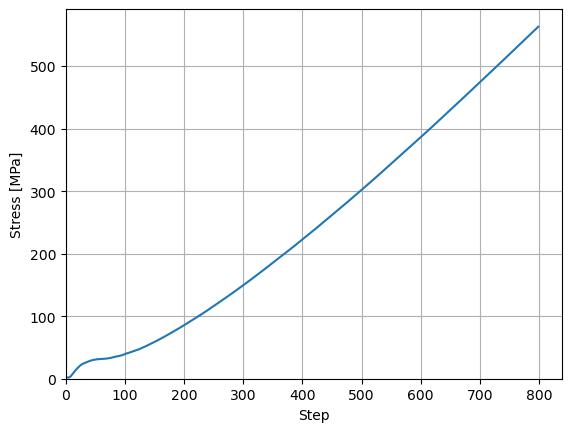

In [4]:
plt.plot(np.array(forces) / AREA)
plt.xlabel("Step")
plt.ylabel("Stress [MPa]")
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

## Visualize displacement data as interactive plot

In [5]:
def plot_nodal_displacements(n):
    pos = positions[n]
    disp = pos - positions[0]
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
    for i in range(3):
        contour = ax[i].scatter(pos[:, 0], pos[:, 1], c=disp[:, i], s=1)
        ax[i].set_xlabel("x in mm")
        ax[i].set_ylabel("y in mm")
        ax[i].set_title(f"Displacement in {DIRS[i]} in mm")
        ax[i].axis("equal")
        plt.colorbar(contour, ax=ax[i])
    plt.tight_layout()
    plt.show()


widgets.interact(plot_nodal_displacements,n=widgets.IntSlider(value=N-1, min=0, max=N-1, step=1))

interactive(children=(IntSlider(value=799, description='n', max=799), Output()), _dom_classes=('widget-interac…

<function __main__.plot_nodal_displacements(n)>

# Triangulate the displacement data to compute gradients

In [6]:
# Build a triangulation
pos = positions[0]
tri = Triangulation(pos[:,0], pos[:,1])

# Mask low quality elements at the boundary
mask = TriAnalyzer(tri).get_flat_tri_mask(.01)
tri.set_mask(mask)

# Compute nodes and centers of each triangle
tria_nodes = pos[tri.triangles]
center_x = np.mean(tri.x[tri.triangles], axis=1)
center_y = np.mean(tri.y[tri.triangles], axis=1)


In [7]:
def plot_triangulated_displacement(n):
    pos = positions[n]
    disp = pos - positions[0]
    tria_nodes = pos[tri.triangles][:,:,0:2]

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
    u_x = LinearTriInterpolator(tri, disp[:,0])
    u_y = LinearTriInterpolator(tri, disp[:,1])
    props ={"u_x": u_x(center_x, center_y),
            "u_y": u_y(center_x, center_y), 
            }
    for i, (lbl, u) in enumerate(props.items()):
        pc = PolyCollection(tria_nodes, array=u)
        contour = ax[i].add_collection(pc)
        ax[i].set_title(lbl)
        ax[i].triplot(tri, color="k", lw=0.1)
        ax[i].set_xlabel("x in mm")
        ax[i].set_ylabel("y in mm")
        ax[i].axis("equal")
        plt.colorbar(contour, ax=ax[i])
    plt.tight_layout()
    plt.show()

widgets.interact(plot_triangulated_displacement,n=widgets.IntSlider(value=N-1, min=1, max=N-1, step=1))

interactive(children=(IntSlider(value=799, description='n', max=799, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_triangulated_displacement(n)>

## Compute the gradients of u 
Using the triangulation, we want to calculate the gradients in each element. 

In [8]:
epsilon = [] 

for pos in positions:
    # Compute displacements 
    disp = pos - positions[0]

    # Interpolate displacements with LinearTriInterpolator 
    u_x = LinearTriInterpolator(tri, disp[:,0])
    u_y = LinearTriInterpolator(tri, disp[:,1])

    # Compute gradients -> LinearTriInterpolator.gradient(center_x, center_y)
    (u_xx, u_xy) = u_x.gradient(center_x, center_y)
    (u_yx, u_yy) = u_y.gradient(center_x, center_y)

    # build nabla u
    nabla_u = np.array([[u_xx, u_xy], [u_yx, u_yy]])

    # Compute epsilon
    epsilon.append(0.5*(nabla_u + np.swapaxes(nabla_u, 0, 1)))

In [9]:
def plot_strain(n):
    eps = epsilon[n]
    props ={"ε_xx": eps[0,0],"ε_yy": eps[1,1],"ε_xy": eps[0,1]}
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
    for i, (lbl, e) in enumerate(props.items()):
        pc = PolyCollection(tria_nodes[:,:,0:2], array=e, cmap="magma")
        contour = ax[i].add_collection(pc)
        ax[i].set_title(lbl)
        ax[i].triplot(tri, color="k", lw=0.1)
        ax[i].set_xlabel("x in mm")
        ax[i].set_ylabel("y in mm")
        ax[i].axis("equal")
        plt.colorbar(contour, ax=ax[i])
    plt.tight_layout()
    plt.show()

widgets.interact(plot_strain,n=widgets.IntSlider(value=N-1, min=1, max=N-1, step=1))

interactive(children=(IntSlider(value=799, description='n', max=799, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_strain(n)>

## Plot the stress-strain diagram with E

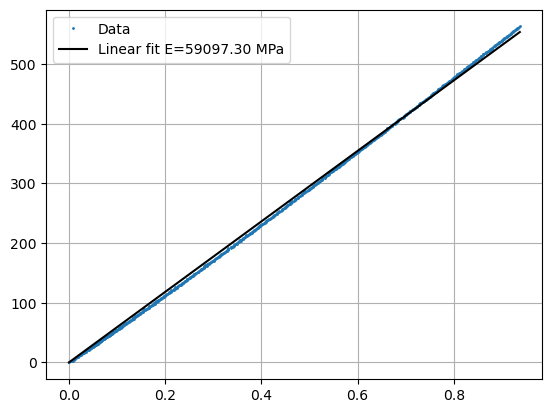

In [10]:
eps_xx_avg = np.array([np.nanmean(eps[0,0]) for eps in epsilon])
eps_yy_avg = np.array([np.nanmean(eps[1,1]) for eps in epsilon])
sigma_yy_avg = np.array(forces)/AREA

A = np.vstack([eps_yy_avg, np.zeros(len(eps_yy_avg))]).T
E, _ = np.linalg.lstsq(A, sigma_yy_avg, rcond=None)[0]
eps_yy_val = np.linspace(0, np.max(eps_yy_avg), 100)

plt.plot(100*eps_yy_avg, sigma_yy_avg, "o", markersize=1, label="Data")
plt.plot(100*eps_yy_val, E* eps_yy_val, "-k", label=f"Linear fit E={E:.2f} MPa")
plt.legend()
plt.grid("on")
plt.show()